In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sympy as sp
import os
import pickle
from sklearn.datasets import load_iris
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

#  Probabilistic Meshless Method

Assume $\mathcal{A}$ and $\mathcal{B}$ are linear operators. Then the posterior distribution $\Pi_{u}^{g, b}$ over the solution of the $P D E$, conditional on the data $\boldsymbol{g}, \boldsymbol{b}$ is such that, for $u \sim \Pi_{u}^{g, b}$ we have
$$
\begin{aligned}
u(X) & \sim \mathcal{N}(\boldsymbol{\mu}, \Sigma) \\
\boldsymbol{\mu} &=\overline{\mathcal{L}} K\left(X, X_{0}\right)\left[\mathcal{L} \overline{\mathcal{L}} K\left(X_{0}, X_{0}\right)\right]^{-1}\left[\begin{array}{ll}
\boldsymbol{g}^{\top} & \boldsymbol{b}^{\top}
\end{array}\right]^{\top} \\
\Sigma &=K(X, X)-\overline{\mathcal{L}} K\left(X, X_{0}\right)\left[\mathcal{L} \overline{\mathcal{L}} K\left(X_{0}, X_{0}\right)\right]^{-1} \mathcal{L} K\left(X_{0}, X\right)
\end{aligned}
$$

where:
$$
\begin{aligned} \mathcal{L} \overline{\mathcal{L}} K\left(X_{0}, X_{0}\right) &=\left[\begin{array}{ll}\mathcal{A} \overline{\mathcal{A}} K\left(X_{0}^{\mathcal{A}}, X_{0}^{\mathcal{A}}\right) & \mathcal{A} \overline{\mathcal{B}} K\left(X_{0}^{\mathcal{A}}, X_{0}^{\mathcal{B}}\right) \\ \mathcal{B} \overline{\mathcal{A}} K\left(X_{0}^{\mathcal{B}}, X_{0}^{\mathcal{A}}\right) & \mathcal{B} \overline{\mathcal{B}} K\left(X_{0}^{\mathcal{B}}, X_{0}^{\mathcal{B}}\right)\end{array}\right] \\ \mathcal{L} K\left(X_{0}, X\right) &=\left[\begin{array}{l}\mathcal{A} K\left(X_{0}^{\mathcal{A}}, X\right) \\ \mathcal{B} K\left(X_{0}^{\mathcal{B}}, X\right)\end{array}\right] \\ \overline{\mathcal{L}} K\left(X, X_{0}\right) &=\left[\begin{array}{ll}\overline{\mathcal{A}} K\left(X, X_{0}^{\mathcal{A}}\right) & \overline{\mathcal{B}} K\left(X, X_{0}^{\mathcal{B}}\right)\end{array}\right] \end{aligned}
$$

In [4]:
class KernelPDE:
    def __init__(self,kernel,X0A,X0B,g,b,X,degree_A,degree_B):
        self.kernel=kernel
        #self.kernel_A = 0
        #self.kernel_Abar = 0
        #self.kernel_B = 0
        #self.kernel_Bbar = 0
        #self.kernel_AAbar=0
        #self.kernel_ABbar=0
        #self.kernel_BAbar=0
        #self.kernel_BBbar=0
        self.X0A=X0A
        self.X0B=X0B
        self.g=g
        self.b=b
        self.X=X
        self.mA=len(self.X0A)
        self.mB=len(self.X0B)
        self.n_test=len(self.X)
        self.degree_A=degree_A
        self.degree_B=degree_B
        
        #self.gammaX0X_matrix=0
        #self.gammabarXX0_matrix=0
        #self.gammagammabar_matrix=0
    def derivative(self):
        x,y=sp.symbols('x y')
        signA=np.sign(self.degree_A)
        signB=np.sign(self.degree_B)
        def A_operator(expression):
            if self.degree_A==0:
                return expression
            else:
                for i in range (np.abs(self.degree_A)):
                    expression=sp.diff(expression,x) 
                return expression*signA
        def Abar_operator(expression):
            if self.degree_A==0:
                return expression
            else:
                for i in range (np.abs(self.degree_A)):
                    expression=sp.diff(expression,y) 
                return expression*signA
        def B_operator(expression):
            if self.degree_B==0:
                return expression
            else:
                for i in range (np.abs(self.degree_B)):
                    expression=sp.diff(expression,x) 
                return expression*signB
        def Bbar_operator(expression):
            if self.degree_B==0:
                return expression
            else:
                for i in range (np.abs(self.degree_B)):
                    expression=sp.diff(expression,y) 
                return expression*signB
        self.kernel_A=A_operator(self.kernel)
        self.kernel_Abar=Abar_operator(self.kernel)
        self.kernel_B=B_operator(self.kernel)
        self.kernel_Bbar=Bbar_operator(self.kernel)
        self.kernel_AAbar=A_operator(Abar_operator(self.kernel))
        self.kernel_ABbar=A_operator(Bbar_operator(self.kernel))
        self.kernel_BAbar=B_operator(Abar_operator(self.kernel))
        self.kernel_BBbar=B_operator(Bbar_operator(self.kernel))
    
        
    
    
    def gammaX0X(self):
        gammaX0X_A=np.zeros((self.mA,self.n_test))
        gammaX0X_B=np.zeros((self.mB,self.n_test))
        for j in range (self.n_test):
            for i in range (self.mA):
                gammaX0X_A[i][j]=self.kernel_A.evalf(subs={x:self.X0A[i][0],y:self.X[j][0]})
            for i in range (self.mB):
                gammaX0X_B[i][j]=self.kernel_B.evalf(subs={x:self.X0B[i][0],y:self.X[j][0]})
        self.gammaX0X_matrix=np.r_[gammaX0X_A,gammaX0X_B]
        
    def gammabarXX0(self):
        gammaXX0_A=np.zeros((self.n_test,self.mA))
        gammaXX0_B=np.zeros((self.n_test,self.mB))
        for i in range (self.n_test):
            for j in range (self.mA):
                gammaXX0_A[i][j]=self.kernel_Abar.evalf(subs={x:self.X[i][0],y:self.X0A[j][0]})
            for j in range (self.mB):
                gammaXX0_B[i][j]=self.kernel_Bbar.evalf(subs={x:self.X[i][0],y:self.X0B[j][0]})
        self.gammabarXX0_matrix=np.c_[gammaXX0_A,gammaXX0_B]       

        
    def gammagammabar(self):
        AAbar=np.zeros((self.mA,self.mA))
        ABbar=np.zeros((self.mA,self.mB))
        BAbar=np.zeros((self.mB,self.mA))
        BBbar=np.zeros((self.mB,self.mB))
        
        
        for i in range (self.mA):
            for j in range (self.mA):
                AAbar[i][j]=self.kernel_AAbar.evalf(subs={x:self.X0A[i][0],y:self.X0A[j][0]})
            for j in range (self.mB):
                ABbar[i][j]=self.kernel_ABbar.evalf(subs={x:self.X0A[i][0],y:self.X0B[j][0]})
        for i in range (self.mB):
            for j in range (self.mA):
                BAbar[i][j]=self.kernel_BAbar.evalf(subs={x:self.X0B[i][0],y:self.X0A[j][0]})
            for j in range (self.mB):
                BBbar[i][j]=self.kernel_BBbar.evalf(subs={x:self.X0B[i][0],y:self.X0B[j][0]})
        upper=np.c_[AAbar,ABbar]
        lower=np.c_[BAbar,BBbar]
        self.gammagammabar_matrix=np.r_[upper,lower]
    
    def kxx(self):
        kxx_matrix=np.zeros((self.n_test,self.n_test))
        for i in range (self.n_test):
            for j in range (self.n_test):
                kxx_matrix[i][j]=self.kernel.evalf(subs={x:self.X[i][0],y:self.X[j][0]})
        self.kxx_matrix=kxx_matrix
    def mu (self):
        self.mu=np.dot(self.gammabarXX0_matrix,np.linalg.pinv(self.gammagammabar_matrix))
        third_mu=np.r_[self.g,self.b]
        self.mu=np.dot(self.mu,third_mu)
    
    def sigma(self):
        second_sigma=np.dot(self.gammabarXX0_matrix,np.linalg.pinv(self.gammagammabar_matrix))
        second_sigma=np.dot(second_sigma,self.gammaX0X_matrix)
        self.sigma= self.kxx_matrix-second_sigma
        
    def PMM (self):
        self.derivative()
        self.gammaX0X()
        self.gammabarXX0()
        self.gammagammabar()
        self.kxx()
        self.mu()
        self.sigma()
        
        return self.mu,self.sigma
    
    
    
 
                


# Simple linear PDE
$$
\mathcal{A}u(x)=g(x) \qquad x\in D\\
\mathcal{B}u(x)=b(x) \qquad x\in \partial D
$$

## Exercise 1 : 

$$
\begin{aligned}\nabla u(x) &=\sin (2 \pi x) & & x \in(0,1) \\ u(x) &=0 & & x=0,1 \end{aligned}
$$

In this exercise, we can get the exact result $u(x)=\frac{-1}{2\pi}\cos(2\pi x)+\frac{1}{2\pi}$

## Exercise 2 : Possion eqation 
$$
\begin{aligned}-\nabla^{2} u(x) &=\sin (2 \pi x) & & x \in(0,1) \\ u(x) &=0 & & x=0,1 \end{aligned}
$$
In this exercise, we can get the exact result $u(x)=\left(2 \pi\right)^{-2} \sin (2 \pi x)$



In [22]:
#build kernel function (RBF)
x,y=sp.symbols('x y')
h=1
kernel=sp.exp(-(x-y)**2/(2*h**2))

#build design points and boundary interval
mA=20
mB=2
X0A = np.linspace(0,1,mA+2)[1:-1, None] # delete 0 and 1 boundary value
X0B=np.array([[0],[1]])

# function g and b by design points
g = np.sin(2*np.pi*X0A)
b = 0*X0B

#define operator A and B

#degree_A=-2
#degree_B=0
degree_A=1
degree_B=0

#test points
n_test=100
X = np.linspace(0,1,n_test)[:,None]

a = KernelPDE(kernel,X0A,X0B,g,b,X,degree_A,degree_B)

mu,sigma=a.PMM()

<ipython-input-24-b18ba7723225>:2: RuntimeWarning: covariance is not positive-semidefinite.
  h_samples = plt.plot(X, np.random.multivariate_normal(mu[:,0], sigma, 20).T, c='gray', alpha=0.5);


(0.0, 1.0)

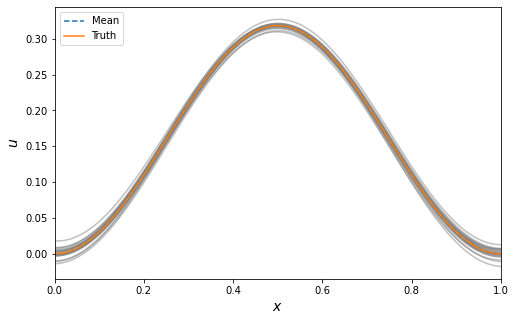

In [24]:
plt.figure(figsize=(8,5))
h_samples = plt.plot(X, np.random.multivariate_normal(mu[:,0], sigma, 20).T, c='gray', alpha=0.5);
h_mean = plt.plot(X, mu, linestyle='--', label='Mean Function')
#h_truth = plt.plot(X, np.sin(2*np.pi*X)/(4*np.pi**2), label='Truth')
h_truth = plt.plot(X, -np.cos(2*np.pi*X)/(2*np.pi)+1/(np.pi*2), label='Truth')

plt.legend((h_mean[0], h_truth[0]), ('Mean', 'Truth', 'Samples'), loc=2)
#plt.ylim(-0.06, 0.06)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$u$', fontsize=14)
#plt.savefig('figures/example_mean_samples.pdf', transparent=True, bbox_inches=0)
plt.xlim(0,1)

In [15]:
#build kernel function (RBF)
x,y=sp.symbols('x y')
h=1
kernel=sp.exp(-(x-y)**2/(2*h**2))

#build design points and boundary interval
mA=20
mB=2
X0A = np.linspace(0,1,mA+2)[1:-1, None] # delete 0 and 1 boundary value
X0B=np.array([[0],[1]])

# function g and b by design points
g = np.sin(2*np.pi*X0A)
b = 0*X0B

#define operator A and B

degree_A=-2
degree_B=0
#degree_A=1
#degree_B=0

#test points
n_test=100
X = np.linspace(0,1,n_test)[:,None]

a = KernelPDE(kernel,X0A,X0B,g,b,X,degree_A,degree_B)

mu,sigma=a.PMM()

<ipython-input-16-145d96ec5ff4>:2: RuntimeWarning: covariance is not positive-semidefinite.
  h_samples = plt.plot(X, np.random.multivariate_normal(mu[:,0], sigma, 20).T, c='gray', alpha=0.5);


(0.0, 1.0)

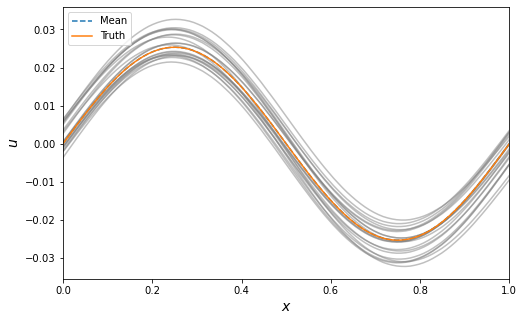

In [16]:
plt.figure(figsize=(8,5))
h_samples = plt.plot(X, np.random.multivariate_normal(mu[:,0], sigma, 20).T, c='gray', alpha=0.5);
h_mean = plt.plot(X, mu, linestyle='--', label='Mean Function')
h_truth = plt.plot(X, np.sin(2*np.pi*X)/(4*np.pi**2), label='Truth')
#h_truth = plt.plot(X, -np.cos(2*np.pi*X)/(2*np.pi)+1/(np.pi*2), label='Truth')

plt.legend((h_mean[0], h_truth[0]), ('Mean', 'Truth', 'Samples'), loc=2)
#plt.ylim(-0.06, 0.06)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$u$', fontsize=14)
#plt.savefig('figures/example_mean_samples.pdf', transparent=True, bbox_inches=0)
plt.xlim(0,1)

# Test the accuracy of the design points

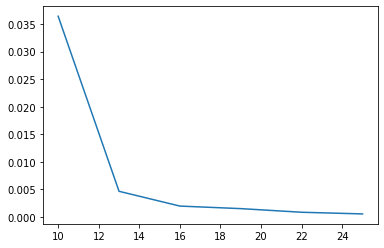

In [20]:
mA_list=np.linspace(10,25,6)
length=len(mA_list)
error=np.zeros((length))

for i in range (length):
    mA=mA_list[i].astype("int")
    mB=2
    X0A = np.linspace(0,1,mA+2)[1:-1, None] # delete 0 and 1 boundary value
    X0B=np.array([[0],[1]])

    # function g and b by design points
    g = np.sin(2*np.pi*X0A)
    b = 0*X0B
    a = KernelPDE(kernel,X0A,X0B,g,b,X,degree_A,degree_B)

    mu,sigma=a.PMM()
    error[i]=np.sum(np.abs(mu-np.sin(2*np.pi*X)/(4*np.pi**2)))
    
plt.plot(mA_list,error)   

In [21]:
print(error)

[0.03639907 0.00466324 0.00198398 0.00152234 0.00086407 0.00056318]
